This notebook determines the input parameters for the simulated datasets.
Based on the object, we look at the diffraction overlap at the various convergence semi-angle values.
We then look into deciding on the probes and step sizes in order to reach a wide range of overlap values.

In [10]:
# %matplotlib qt
%matplotlib inline

In [2]:
import numpy as np
import hyperspy.api as hs
import os
import h5py
import sys

In [3]:
sys.path.append('/dls/science/groups/e02/Mohsen/code/Git_Repos/Merlin-Medipix/')
import epsic_tools.api as epsic

# sim starting parameters:
For instructions on prismatic refer to:
https://prism-em.com/tutorial-SuperSTEM/

Accelerating voltage: 80 kV
 


**Determining sampling conditions**

Aiming for 512*512 detector pixel array, knowing our object is 2 * 43.50 A in size, we can calculate the simulation PixelSize: 

In [4]:
cell_dim = 43.5e-10 #in m
tiling_factor = 2
detector_pix_array = 512
pixel_size = cell_dim*tiling_factor / (2*detector_pix_array)
print('sim pixel size (m): ', pixel_size)

sim pixel size (m):  8.49609375e-12


In [5]:
e_0 = 80000
l = epsic.ptycho_utils.e_lambda(e_0)
alpha_max = l / (4 * pixel_size)
print('This gives us maximum scattering angle of ',np.round(alpha_max,5) * 1e3, 'mrad')

This gives us maximum scattering angle of  122.86999999999999 mrad


We can also now calculate the pixel size in reciprocal plane:

In [6]:
print('mrad per pixel: ', alpha_max * 1e3 / detector_pix_array )
print('pixel per mrad: ', (alpha_max * 1e3 / detector_pix_array)**-1)

mrad per pixel:  0.23998368260249545
pixel per mrad:  4.166949974079619


we can also calculate the camera length:

In [7]:
detector_pixel_size = 55e-6 
CL = (detector_pix_array / 2) * detector_pixel_size / alpha_max
print(CL)

0.11459112428718954


Based on the above convergence semi-angle values, in each case we define the follwoing probe:

with maximum defocus - defined as the probe with diameter equal to half the reconstrction array, 


In [8]:
probe_diameter = pixel_size * detector_pix_array / 2
print(probe_diameter)

2.175e-09


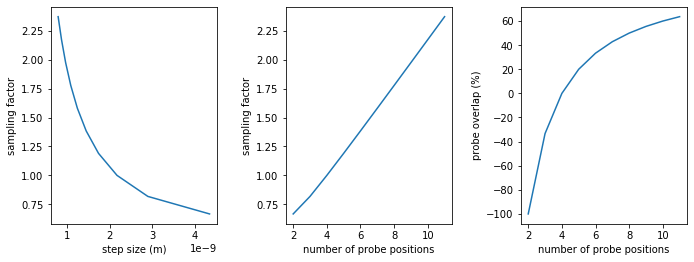

In [11]:
number_probe_pos = np.arange(2, 100)
step_size = cell_dim * tiling_factor / number_probe_pos
s_factor = epsic.ptycho_utils.get_sampling_factor(pixel_size * detector_pix_array, probe_diameter, number_probe_pos, step_size)
probe_overlap = epsic.sim_utils.get_overlap(probe_diameter/2, step_size)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.plot(step_size[:10], s_factor[:10])
plt.xlabel('step size (m)')
plt.ylabel('sampling factor')
plt.subplot(1, 3, 2)
plt.plot(number_probe_pos[:10], s_factor[:10])
plt.xlabel('number of probe positions')
plt.ylabel('sampling factor')
plt.subplot(1, 3, 3)
plt.plot(number_probe_pos[:10], probe_overlap[:10])
plt.xlabel('number of probe positions')
plt.ylabel('probe overlap (%)')
plt.tight_layout(pad = 2)

So we need to have more than 4 probe positionsin each direction, equivalent to zero percent probe overlap, to have sampling factor more than 1. 

In [12]:
print(pixel_size)
image_size = [detector_pix_array, detector_pix_array]
print('electron wavelength (m): ', l)
conv_semi_list = [0.008, 0.010, 0.012, 0.015, 0.020, 0.025, 0.032, 0.042]
def_vals = [] 
probes = []

for angle in conv_semi_list:  
    def_val = epsic.sim_utils.max_defocus(pixel_size, image_size, l, angle)
    print('probe with convergence semi-angle ', angle, ' mrad will need defocus of: ',def_val, 'm')
    def_vals.append(def_val)
    probe = epsic.sim_utils.calc_probe_size(pixel_size, image_size, l, def_val, angle, plot_probe= False, return_probeArr= True)
    probes.append(probe)
probes = np.asanyarray(probes)

8.49609375e-12
electron wavelength (m):  4.175716077283421e-12
target probe radius(m): 1.0875e-09
probe with convergence semi-angle  0.008  mrad will need defocus of:  2.813459998762848e-08 m
target probe radius(m): 1.0875e-09
probe with convergence semi-angle  0.01  mrad will need defocus of:  2.604637497583561e-08 m
target probe radius(m): 1.0875e-09
probe with convergence semi-angle  0.012  mrad will need defocus of:  2.4420649958240884e-08 m
target probe radius(m): 1.0875e-09
probe with convergence semi-angle  0.015  mrad will need defocus of:  2.2294562418436144e-08 m
target probe radius(m): 1.0875e-09
probe with convergence semi-angle  0.02  mrad will need defocus of:  1.9767749806658994e-08 m
target probe radius(m): 1.0875e-09
probe with convergence semi-angle  0.025  mrad will need defocus of:  1.809093712237313e-08 m
target probe radius(m): 1.0875e-09
probe with convergence semi-angle  0.032  mrad will need defocus of:  1.6172774208029276e-08 m
target probe radius(m): 1.0875e-

In [13]:
def_vals

[2.813459998762848e-08,
 2.604637497583561e-08,
 2.4420649958240884e-08,
 2.2294562418436144e-08,
 1.9767749806658994e-08,
 1.809093712237313e-08,
 1.6172774208029276e-08,
 1.43776303520962e-08]

In [14]:
probes.shape

(8, 2)

**Total number of cases: 64**

8 probes (all defocussed)
each case to be rastered on cell with 8 different probe overlap values

Total : 8 * 8

In [15]:
conv_semi_list

[0.008, 0.01, 0.012, 0.015, 0.02, 0.025, 0.032, 0.042]

In [16]:
probe_overlaps = [0, 5, 15, 35, 60, 70, 80, 90]
step_sizes = []
for i in np.arange(probes.shape[0]):
    for overlap in probe_overlaps:
        step_sizes.append(epsic.sim_utils.get_step_size(probes[i][0], overlap / 100))


In [17]:
len(probe_overlaps)

8

[Text(0, 0.5, 'step size (m)'),
 Text(0.5, 1.0, 'scan step sizes for target overlap values')]

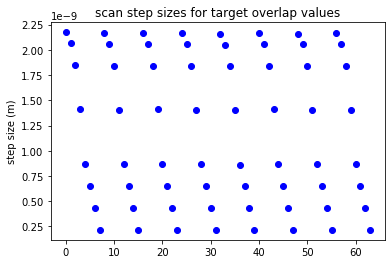

In [18]:
fig, ax = plt.subplots()

ax.plot(step_sizes, 'bo')

# ax.annotate('Focussed probes', xy=(15, 1.6e-9),
#             bbox=dict(boxstyle="round", fc="none", ec="gray"),
#             xytext=(10, 5e-10), textcoords='offset points', ha='center')
# ax.annotate('Defocussed probes', xy=(65, 1.6e-9),
#             bbox=dict(boxstyle="round", fc="none", ec="gray"),
#             xytext=(60, 5e-10), textcoords='offset points', ha='center')
ax.set(title='scan step sizes for target overlap values',
       ylabel='step size (m)')

Text(0.5, 0, 'sim conditions')

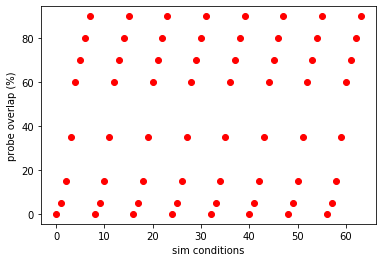

In [19]:
probe_overlaps_all = probe_overlaps * probes.shape[0]
plt.plot(probe_overlaps_all, 'ro')
plt.ylabel('probe overlap (%)')
plt.xlabel('sim conditions')

In [20]:
len(probe_overlaps_all)

64

Text(0.5, 0, 'sim conditions')

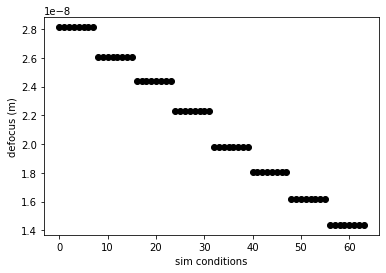

In [21]:
def_vals_all = [y for x in def_vals for y in (x,)*len(probe_overlaps)]
plt.plot(def_vals_all, 'ko')
plt.ylabel('defocus (m)')
plt.xlabel('sim conditions')

Text(0.5, 0, 'sim conditions')

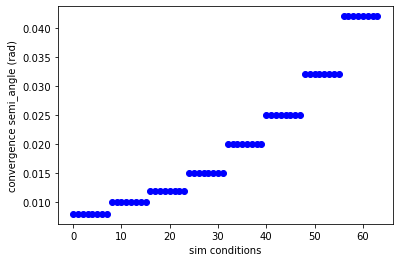

In [22]:
conv_semi_all = [y for x in conv_semi_list for y in (x,)*len(probe_overlaps)]
plt.plot(conv_semi_all, 'bo')
plt.ylabel('convergence semi_angle (rad)')
plt.xlabel('sim conditions')

In [23]:
conv_semi_all = np.asarray(conv_semi_all)
def_vals_all = np.asarray(def_vals_all)
step_sizes = np.asarray(step_sizes)
numbers_probe_pos = cell_dim * tiling_factor / step_sizes
sampling_factors = epsic.ptycho_utils.get_sampling_factor(pixel_size*detector_pix_array, probe_diameter, numbers_probe_pos, step_sizes)
sim_conditions = np.vstack((conv_semi_all, def_vals_all, step_sizes, sampling_factors))

In [24]:
print('sampling factor now ranges from ', min(sampling_factors), ' to ', max(sampling_factors))

sampling factor now ranges from  1.0003472075729518  to  8.2206198912873


In [25]:
sim_conditions[:,4]
# convergence semi-angle (rad), defocus (m), step_size (m)

array([8.00000000e-03, 2.81346000e-08, 8.69597441e-10, 2.17483190e+00])

In [26]:
sim_conditions.shape

(4, 64)

In [31]:
np.save('sim_condtions_64cases_def_512det_amC', sim_conditions)

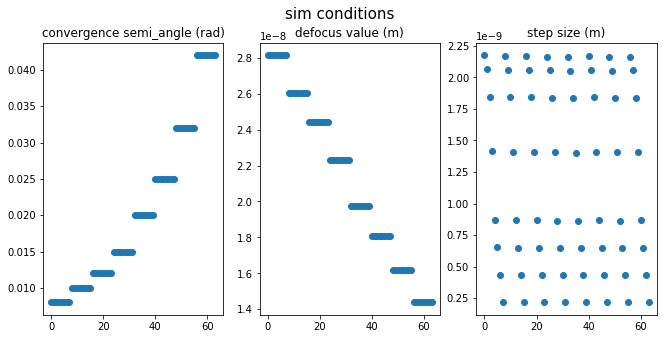

In [27]:
fig, axs = plt.subplots(1,3, figsize=(11, 5))
title = 'sim conditions'
fig.suptitle(title, fontsize = 15)

for i, ax in enumerate(axs.ravel()):
    ax.plot(sim_conditions[i,:], 'o')
    if i==0:
        ax.set_title('convergence semi_angle (rad)')
    if i==1:
        ax.set_title('defocus value (m)')
    if i==2:
        ax.set_title('step size (m)')


# Submitting the sim matrix to cluster

In [33]:
pixel_size

8.49609375e-12

In [34]:
xyz = '/dls/science/groups/e02/Mohsen/code/Git_Repos/Staff-notebooks/ptyREX_sim_matrix/xyz_files/amorCarbon_43p5nmCube.xyz'
sim_npy = '/dls/science/groups/e02/Mohsen/code/Git_Repos/Staff-notebooks/ptyREX_sim_matrix/sim_condtions_64cases_def_512det_amC.npy'
root_path = '/dls/e02/data/2020/cm26481-1/processing/pty_simulated_data_MD/sim_matrix_ptyREX_amC_16June2020_512pixArray/'
script_path = '/dls/science/groups/e02/Mohsen/code/Git_Repos/Staff-notebooks/ptyREX_sim_matrix/'
dose = 2.5e8
shell_file = '/dls/science/groups/e02/Mohsen/code/Git_Repos/Staff-notebooks/ptyREX_sim_matrix/pyprismatic_matrix.sh'


In [35]:
import sys
import os
sys.path.append(script_path)

In [36]:
command_str = '\n cd '+ script_path + '\n module load global/cluster \n qsub pyprismatic_matrix.sh ' + xyz + ' ' + str(pixel_size)+ ' '+ sim_npy + ' ' + root_path + ' ' + script_path + ' ' + str(dose)
os.system(command_str)

0